# SNIR+GAT
- 任务1：跨个体估计任务特定的脑区影响因子 $\rho_j$
- 任务2：使用 $\rho_j$ 调节GAT架构（暂时从偏置入手），做多任务预测（集中`SRS量表`）

> 数据基于`hx`

## 任务1-跨个体估计任务特定的脑区影响因子 $\rho_j$

1. 依赖包和路径

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

DATA_DIR = 'hx/'  # 存放 FC 矩阵的路径
INFO_PATH = 'hxinfo.csv'
NODE_INFO_PATH = 'x_dosenbach.csv'
TIMECOURSE_DIR = 'hxtimecourse/'
# 回归目标（可以替换为 SRS_awareness 等）
TARGET_COL = 'SRS_communication'

2. 表型信息读取+ID提取

In [3]:
info_df = pd.read_csv(INFO_PATH)
print(f"共读取被试数量: {len(info_df)}")

# 选定目标列作为 y
y_all = info_df[[TARGET_COL, 'ID']].dropna()
y_all = y_all.reset_index(drop=True)
print(f"包含目标 {TARGET_COL} 的有效被试数: {len(y_all)}")

# 将 ID 匹配为 z<ID>.txt 文件路径
y_all['A_path'] = y_all['ID'].apply(lambda x: os.path.join(DATA_DIR, f'z{x}.txt'))

共读取被试数量: 218
包含目标 SRS_communication 的有效被试数: 218


3. 节点特征Y（取静态结构特征和时间序列统计特征及频域特征）

In [4]:
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft, fftfreq

node_df = pd.read_csv(NODE_INFO_PATH)
Y_xyz = node_df[['x(mm)', 'y(mm)', 'z(mm)']].values.astype(float)
scaler_y = StandardScaler()
Y_xyz_std = scaler_y.fit_transform(Y_xyz)  # (160, 3)

subnet_onehot = pd.get_dummies(node_df['Subnetwork'])  # (160, ?)
node_static_feat = np.concatenate([Y_xyz_std, subnet_onehot.values], axis=1)  # shape = (160, 3 + N)

# === 定义频域特征函数 ===
def compute_frequency_features(ts, fs=1.0):
    N = len(ts)
    freqs = fftfreq(N, d=1/fs)
    fft_vals = np.abs(fft(ts))[:N // 2]
    freqs = freqs[:N // 2]

    total_power = np.sum(fft_vals**2)
    dominant_freq = freqs[np.argmax(fft_vals)]
    # mean_freq = np.sum(freqs * fft_vals) / np.sum(fft_vals)
    # band_power = np.sum(fft_vals[(freqs >= 0.01) & (freqs <= 0.1)]**2)

    return [total_power, dominant_freq]

# === 每个被试提取特征 ===
all_features = []
valid_timecourse_ids = []  # 重命名为更清晰的名称

for idx, row in y_all.iterrows():
    subj_id = row['ID']
    path = os.path.join(TIMECOURSE_DIR, f'{subj_id}.txt')

    if not os.path.exists(path):
        print(f"[警告] 缺失文件: {path}")
        continue

    ts_matrix = np.loadtxt(path)  # shape: (129, 160)
    node_features = []

    for i in range(ts_matrix.shape[1]):  # 对每个节点
        ts = ts_matrix[:, i]

        # 统计特征
        stats = [
            np.mean(ts),
            np.std(ts),
            # np.min(ts),
            # np.max(ts),
            # np.percentile(ts, 25),
            # np.percentile(ts, 50),
            # np.percentile(ts, 75),
        ]

        # 频域特征
        freq_feats = compute_frequency_features(ts)

        # 拼接节点特征： 静态 + 动态
        feats = np.concatenate([node_static_feat[i], stats, freq_feats])  # shape = (13,)
        node_features.append(feats)

    node_features = np.stack(node_features, axis=0)  # shape = (160, 13)
    all_features.append(node_features)
    valid_timecourse_ids.append(subj_id)

all_features = np.stack(all_features, axis=0)  # shape = (N, 160, 13)
print("最终特征矩阵 shape:", all_features.shape)
np.save('FEATURE_IDS.npy', np.array(valid_timecourse_ids))

[警告] 缺失文件: hxtimecourse/ASD1013.txt
[警告] 缺失文件: hxtimecourse/ASD1018 .txt
[警告] 缺失文件: hxtimecourse/ASD1051.txt
[警告] 缺失文件: hxtimecourse/ASD1075.txt
[警告] 缺失文件: hxtimecourse/ASD1112.txt
[警告] 缺失文件: hxtimecourse/ASD1115.txt
[警告] 缺失文件: hxtimecourse/ASD1125.txt
[警告] 缺失文件: hxtimecourse/ASD1132.txt
[警告] 缺失文件: hxtimecourse/ASD1133.txt
[警告] 缺失文件: hxtimecourse/TD139.txt
[警告] 缺失文件: hxtimecourse/TD208.txt
[警告] 缺失文件: hxtimecourse/TD226.txt
[警告] 缺失文件: hxtimecourse/TD249.txt
最终特征矩阵 shape: (205, 160, 13)


In [5]:
len(valid_timecourse_ids)

205

In [6]:
np.save('all_features.npy', all_features)
timecourse_id_to_idx = {id: idx for idx, id in enumerate(valid_timecourse_ids)}

4. Z构造（传播响应）
    - 每个被试 Z = A * all_features
    - all_features = \[xyz_std + subnet_onehot + timecourse_feature\]（拼接中心坐标与子网络one-hot、时间序列特征）

In [7]:
Z_list = []
valid_adjacency_ids = []
for idx, row in y_all.iterrows():
    subj_id = row['ID']
    # 检查该ID是否有时间序列特征
    if subj_id not in timecourse_id_to_idx:
        print(f"跳过 {subj_id}，缺少时间序列特征")
        continue
        
    try:
        A = np.loadtxt(row['A_path'])
        if A.shape != (160, 160):
            print(f"跳过 {subj_id}，尺寸不符: {A.shape}")
            continue
            
        # 获取对应的特征矩阵
        feat_idx = timecourse_id_to_idx[subj_id]
        node_features = all_features[feat_idx]
        
        Z = A @ node_features    # shape: (160, 13)
        Z_flat = Z.flatten()     # shape: (160 * 13 = ,)
        Z_list.append(Z_flat)
        valid_adjacency_ids.append(subj_id)
    except Exception as e:
        print(f"跳过 {subj_id}，读取失败: {e}")
Z_all = np.stack(Z_list, axis=0)  # shape: (M, )
print(f"成功处理样本数量: {len(Z_all)}")

跳过 ASD1013，缺少时间序列特征
跳过 ASD1018 ，缺少时间序列特征
跳过 ASD1051，缺少时间序列特征
跳过 ASD1075，缺少时间序列特征
跳过 ASD1112，缺少时间序列特征
跳过 ASD1115，缺少时间序列特征
跳过 ASD1125，缺少时间序列特征
跳过 ASD1132，缺少时间序列特征
跳过 ASD1133，缺少时间序列特征
跳过 ASD1145，读取失败: hx/zASD1145.txt not found.
跳过 ASD1147，读取失败: hx/zASD1147.txt not found.
跳过 ASD1149，读取失败: hx/zASD1149.txt not found.
跳过 ASD1150，读取失败: hx/zASD1150.txt not found.
跳过 TD139，缺少时间序列特征
跳过 TD208，缺少时间序列特征
跳过 TD226，缺少时间序列特征
跳过 TD249，缺少时间序列特征
成功处理样本数量: 201


In [8]:
# === 对齐特征和标签 ===
aligned_features = []
for subj_id in valid_adjacency_ids:
    feat_idx = timecourse_id_to_idx[subj_id]
    aligned_features.append(all_features[feat_idx])

Y_aligned = np.stack(aligned_features, axis=0)  # shape: (N_valid, 160, 13)
y_final = y_all[y_all['ID'].isin(valid_adjacency_ids)][TARGET_COL].values  # shape: (N_valid,)

print(f"特征矩阵大小: {Y_aligned.shape}, 目标变量大小: {y_final.shape}")

特征矩阵大小: (201, 160, 13), 目标变量大小: (201,)


In [10]:
np.save('Y.npy', Y_aligned)

5. 估计$\rho_j$，**暂时采用任务相关性**



In [29]:
# 平均每个 ROI 的特征（跨维度）
# roi_mean_feats = Y_aligned.mean(axis=2)  # shape: (N, 160)
# 对每个 ROI，计算与 y 的 Pearson 相关系数
from scipy.stats import pearsonr

for i in range(160):
    for j in range(13):
        feature_values = Y_aligned[:, i, j]
        if np.all(feature_values == feature_values[0]):
            pass
        # print(f"ROI节点 {i}, 特征维度 {j} 是常量值 {feature_values[0]}")

            rho_est = np.zeros((160, 13))
for i in range(160):
    for j in range(13):
        feature_values = Y_aligned[:, i, j]
        # 检查是否为常量数组
        if np.all(feature_values == feature_values[0]):
            # 常量特征与目标变量无相关性，设置为0或NaN
            rho_est[i, j] = 0  # 或 np.nan
            # print(f"ROI节点 {i}, 特征维度 {j} 是常量，无法计算相关性")
        else:
            r, _ = pearsonr(feature_values, y_final)
            rho_est[i, j] = r

# 保存为 npy 供 GNN 后续使用
np.save('rho_estimate.npy', rho_est)
print("基于任务目标的相关性 rho 已保存为 rho_estimate.npy")
rho_est.shape

基于任务目标的相关性 rho 已保存为 rho_estimate.npy


(160, 13)

6. output & visualization

Top 10 影响脑区：（基于L2范数）


,Labels,Regions,Hemishpere,rho
1,2,mPFC,NaN,0.323921
7,8,ACC,R,0.317318
5,6,vmPFC,L,0.314506
3,4,vmPFC,R,0.291522
40,41,ACC,L,0.290556
4,5,vmPFC,L,0.280800
35,36,aPFC,L,0.278243
57,58,ACC,L,0.278216
38,39,vlPFC,R,0.270070
0,1,vmPFC,R,0.266778


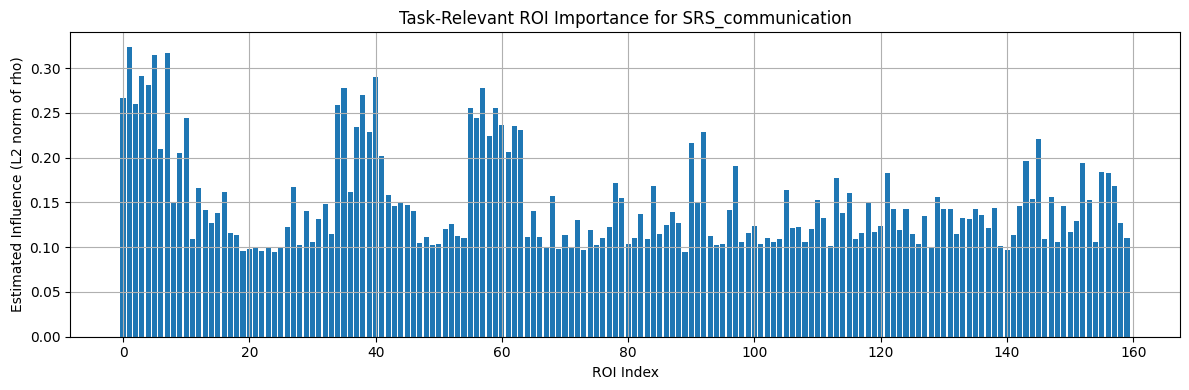

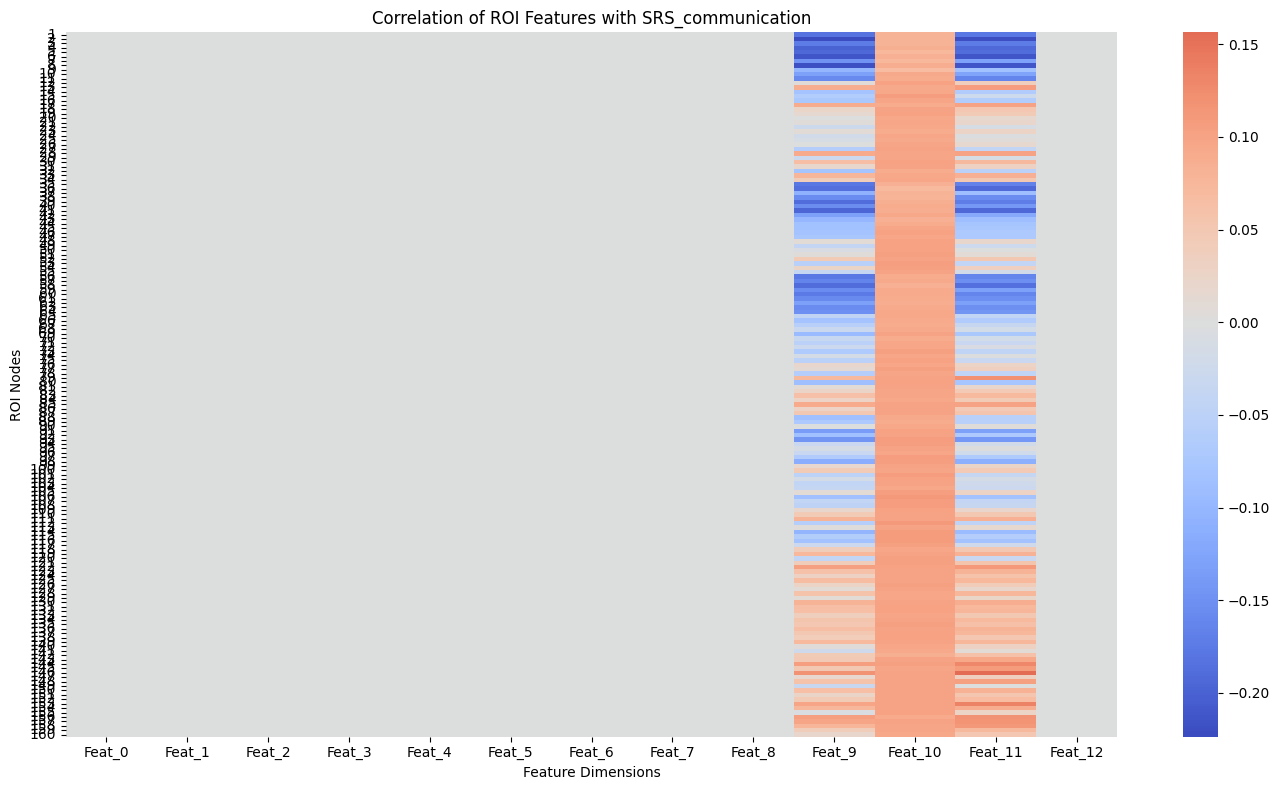

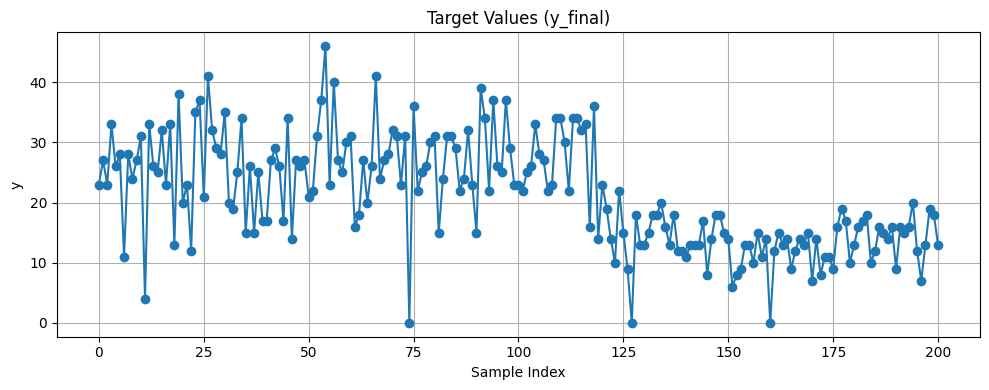

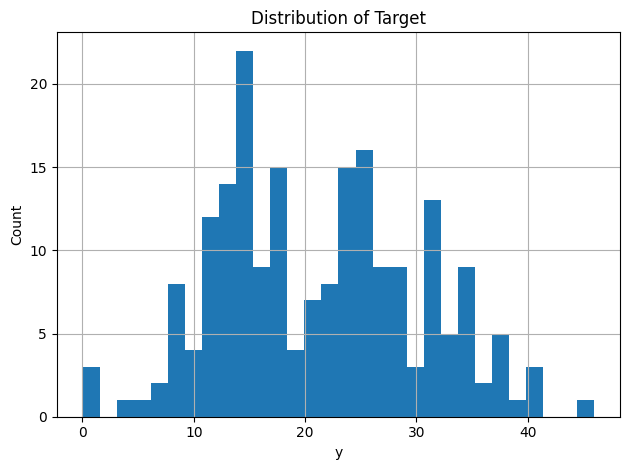

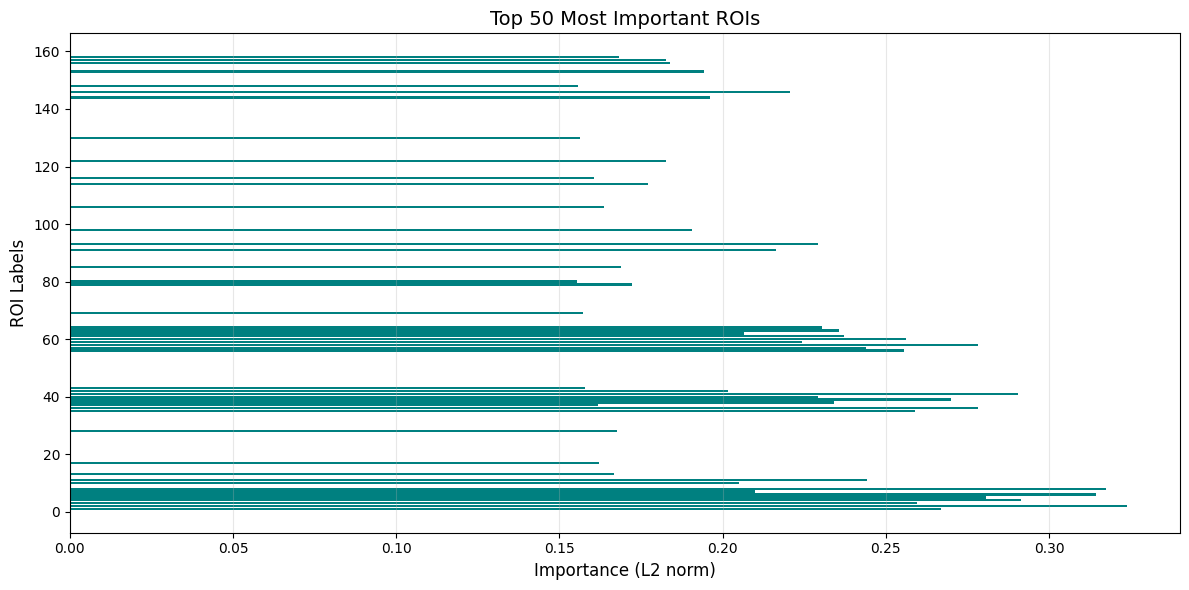

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# 排序并显示 top 10 ROI
node_df['rho'] = np.linalg.norm(rho_est, axis=1)  # L2范数
node_df_sorted = node_df.sort_values('rho', ascending=False)
print("Top 10 影响脑区：（基于L2范数）")
display(node_df_sorted[['Labels', 'Regions', 'Hemishpere', 'rho']].head(10))

# 可视化
plt.figure(figsize=(12, 4))
plt.bar(np.arange(160), node_df['rho'])
plt.xlabel('ROI Index')
plt.ylabel('Estimated Influence (L2 norm of rho)')
plt.title(f'Task-Relevant ROI Importance for {TARGET_COL}')
plt.grid(True)
plt.tight_layout()
plt.savefig('task_rho_fig/roi_importance.png', dpi=300)
plt.show()

# 热力图
plt.figure(figsize=(14, 8))
sns.heatmap(rho_est, cmap='coolwarm', center=0, 
            xticklabels=[f'Feat_{i}' for i in range(13)],
            yticklabels=node_df['Labels'].values if len(node_df) == 160 else None)
plt.xlabel('Feature Dimensions')
plt.ylabel('ROI Nodes')
plt.title(f'Correlation of ROI Features with {TARGET_COL}')
plt.tight_layout()
plt.savefig('task_rho_fig/correlation_heatmap.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(y_final, marker='o')
plt.title("Target Values (y_final)")
plt.xlabel("Sample Index")
plt.ylabel("y")
plt.grid(True)
plt.tight_layout()
plt.savefig('task_rho_fig/y.png', dpi=300)
plt.show()

plt.hist(y_final, bins=30)
plt.title("Distribution of Target")
plt.xlabel("y")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig('task_rho_fig/target_distribution.png', dpi=300)
plt.show()

# 汇总多个重要ROI的图表
top_n = 50  # 显示前50个重要ROI
plt.figure(figsize=(12, 6))
top_rois = node_df_sorted.head(top_n)
plt.barh(top_rois['Labels'], top_rois['rho'], color='teal')
plt.xlabel('Importance (L2 norm)', fontsize=12)
plt.ylabel('ROI Labels', fontsize=12)
plt.title(f'Top {top_n} Most Important ROIs', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(f'task_rho_fig/top_rois{top_n}.png', dpi=300)
plt.show()

In [13]:
import numpy as np

A = np.loadtxt('hx/zASD1002.txt')
def is_undirected(A, tol=1e-8):
    return np.allclose(A, A.T, atol=tol)
is_undirected(A, tol=1e-8)

True

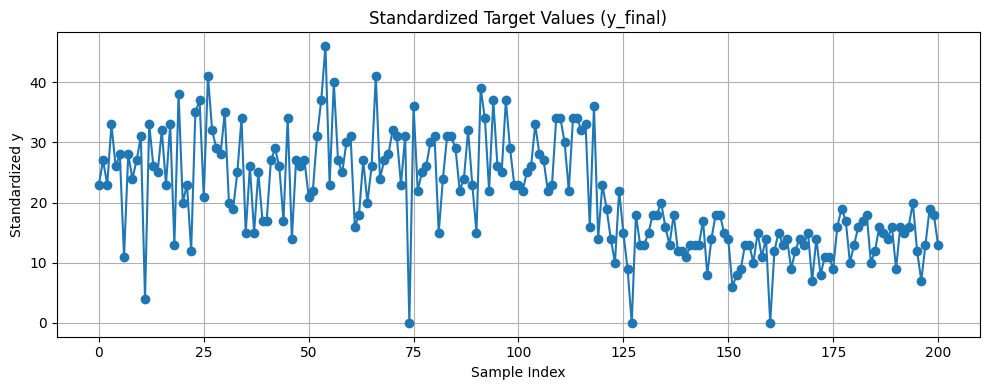

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_final, marker='o')
plt.title("Standardized Target Values (y_final)")
plt.xlabel("Sample Index")
plt.ylabel("Standardized y")
plt.grid(True)
plt.tight_layout()
plt.show()

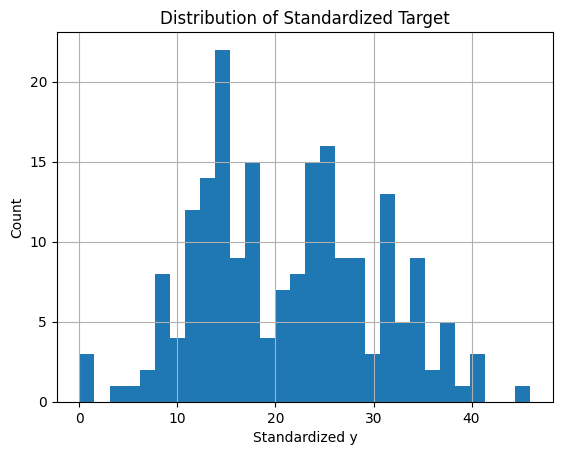

In [17]:
plt.hist(y_final, bins=30)
plt.title("Distribution of Standardized Target")
plt.xlabel("Standardized y")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [1]:
rho_est.shape


NameError: name 'rho_est' is not defined

In [19]:
import os

root_dir = '/root/autodl-tmp/snir+gat'
def print_tree(root_dir, prefix=""):
    entries = sorted(os.listdir(root_dir))
    for i, entry in enumerate(entries):
        path = os.path.join(root_dir, entry)
        connector = "├── " if i < len(entries) - 1 else "└── "
        print(prefix + connector + entry)
        if os.path.isdir(path):
            extension = "│   " if i < len(entries) - 1 else "    "
            print_tree(path, prefix + extension)
print_tree(root_dir, prefix="")

├── .ipynb_checkpoints
│   ├── config-checkpoint.py
│   ├── preprocess-checkpoint.py
│   └── run_task2-checkpoint.py
├── __pycache__
│   ├── config.cpython-38.pyc
│   └── run_task2.cpython-38.pyc
├── checkpoints
│   ├── best_model.pt
│   └── gat_full_checkpoint.pt
├── config.py
├── data
│   └── processed_dataset.pt
├── models
│   ├── .ipynb_checkpoints
│   │   ├── rho_adjusted_gat-checkpoint.py
│   │   └── vanilla_gat-checkpoint.py
│   ├── __pycache__
│   │   ├── rho_adjusted_gat.cpython-38.pyc
│   │   └── vanilla_gat.cpython-38.pyc
│   ├── rho_adjusted_gat.py
│   └── vanilla_gat.py
├── preprocess.py
├── results
│   ├── .ipynb_checkpoints
│   ├── run_20250416_003417
│   │   ├── .ipynb_checkpoints
│   │   │   ├── best_epoch-checkpoint.txt
│   │   │   └── metrics_log-checkpoint.csv
│   │   ├── best_epoch.txt
│   │   ├── checkpoints
│   │   │   └── best_checkpoint.pt
│   │   ├── figures
│   │   │   ├── .ipynb_checkpoints
│   │   │   │   ├── pred_vs_target-checkpoint.png
│   │   │   │   └─

## 任务1-用abide尝试

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

DATA_DIR = 'abide1/'  # 存放 FC 矩阵的路径
INFO_PATH = 'abide1info.csv'
NODE_INFO_PATH = 'x_dosenbach.csv'
TIME_COURSE = 'timecourse/'

# 回归目标（可以替换为 SRS_awareness 等）
TARGET_COL = 'FIQ'

# 正则化参数搜索范围
ALPHA_GRID = np.logspace(-4, 1, 30)

- 生成 ID 和路径,患病标签

In [4]:
import re
import glob

# === 读取结构连接文件名 ===
struct_files = glob.glob(os.path.join(DATA_DIR, 'z*.txt'))

# === 解析文件名，提取 SUB_ID 和 ASD 标签 ===
file_info_list = []
for f in struct_files:
    match = re.match(r'z(ASD|TC)(\d{5})\.txt', os.path.basename(f))
    if match:
        label, subid = match.groups()
        subid = int(subid)
        file_info_list.append({
            'SUB_ID': subid,
            'ASD': 1 if label == 'ASD' else 0,
            'A_path': f,
            'T_path': os.path.join(TIME_COURSE, f'z{label}{subid:05d}.txt')
        })

# === 合并 info_df 和文件路径（只保留有配套文件的） ===
file_df = pd.DataFrame(file_info_list)
merged_df = pd.merge(info_df, file_df, on='SUB_ID', how='inner')

# === 清除无效 target ===
merged_df = merged_df[(merged_df[TARGET_COL].notna()) & (merged_df[TARGET_COL] != -9999)].reset_index(drop=True)

print(f"最终有效样本数量: {len(merged_df)}")


最终有效样本数量: 161


In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# === 加载节点信息 ===
node_df = pd.read_csv(NODE_INFO_PATH)
Y_xyz = node_df[['x(mm)', 'y(mm)', 'z(mm)']].values.astype(float)
Y_xyz_std = StandardScaler().fit_transform(Y_xyz)
subnet_onehot = pd.get_dummies(node_df['Subnetwork'])
Y_enriched = np.concatenate([Y_xyz_std, subnet_onehot.values], axis=1)  # shape: (160, 9)

# === 提取特征 ===
Z_list = []
y_list = []
asd_list = []
valid_sub_ids = []

for _, row in merged_df.iterrows():
    try:
        # --- 加载结构连接矩阵 ---
        A = np.loadtxt(row['A_path'])
        if A.shape != (160, 160):
            print(f"跳过 {row['SUB_ID']}：结构连接尺寸错误 {A.shape}")
            continue

        # --- 加载时间序列 ---
        if not os.path.exists(row['T_path']):
            print(f"跳过 {row['SUB_ID']}：时间序列文件缺失")
            continue

        T = np.loadtxt(row['T_path'])  # shape: (t, 160)
        if T.ndim != 2 or T.shape[1] != 160:
            print(f"跳过 {row['SUB_ID']}：时间序列维度异常 {T.shape}")
            continue

        # --- 时间序列统计特征 ---
        time_mean = np.mean(T, axis=0)   # (160,)
        time_std = np.std(T, axis=0)     # (160,)
        time_features = np.concatenate([time_mean, time_std], axis=0)  # (320,)

        # --- 结构连接特征 ---
        Z = A @ Y_enriched               # (160, 9)
        Z_flat = Z.flatten()             # (1440,)

        # --- 合并成最终特征 ---
        Z_combined = np.concatenate([Z_flat, time_features])  # (1760,)

        Z_list.append(Z_combined)
        y_list.append(row[TARGET_COL])
        asd_list.append(row['ASD'])
        valid_sub_ids.append(row['SUB_ID'])

    except Exception as e:
        print(f"跳过 {row['SUB_ID']}：异常 {e}")

# === 转换为 numpy 数组 ===
Z_all = np.stack(Z_list, axis=0)
y_final = np.array(y_list)
asd_flags = np.array(asd_list)

print(f"成功提取特征样本数: {len(Z_all)}")

# === 标准化 ===
Z_scaled = StandardScaler().fit_transform(Z_all)
y_scaled = (y_final - y_final.mean()) / y_final.std()


跳过 50182：时间序列文件缺失
跳过 50183：时间序列文件缺失
跳过 50184：时间序列文件缺失
跳过 50186：时间序列文件缺失
跳过 50187：时间序列文件缺失
跳过 50188：时间序列文件缺失
跳过 50189：时间序列文件缺失
跳过 50190：时间序列文件缺失
跳过 50191：时间序列文件缺失
跳过 50207：时间序列文件缺失
跳过 50212：时间序列文件缺失
跳过 50216：时间序列文件缺失
跳过 50193：时间序列文件缺失
跳过 50194：时间序列文件缺失
跳过 50195：时间序列文件缺失
跳过 50196：时间序列文件缺失
跳过 50197：时间序列文件缺失
跳过 50198：时间序列文件缺失
跳过 50199：时间序列文件缺失
跳过 50200：时间序列文件缺失
跳过 50201：时间序列文件缺失
跳过 50202：时间序列文件缺失
跳过 50203：时间序列文件缺失
跳过 50204：时间序列文件缺失
跳过 50205：时间序列文件缺失
跳过 50208：时间序列文件缺失
跳过 50209：时间序列文件缺失
跳过 50210：时间序列文件缺失
跳过 50211：时间序列文件缺失
跳过 50213：时间序列文件缺失
跳过 50214：时间序列文件缺失
跳过 50215：时间序列文件缺失
跳过 50217：时间序列文件缺失
跳过 50791：时间序列文件缺失
跳过 50792：时间序列文件缺失
跳过 50794：时间序列文件缺失
跳过 50795：时间序列文件缺失
跳过 50797：时间序列文件缺失
跳过 50798：时间序列文件缺失
跳过 50799：时间序列文件缺失
跳过 50801：时间序列文件缺失
跳过 50802：时间序列文件缺失
跳过 50803：时间序列文件缺失
跳过 50804：时间序列文件缺失
跳过 50823：时间序列文件缺失
跳过 50824：时间序列文件缺失
跳过 50825：时间序列文件缺失
跳过 50772：时间序列文件缺失
跳过 50773：时间序列文件缺失
跳过 50774：时间序列文件缺失
跳过 50775：时间序列文件缺失
跳过 50777：时间序列文件缺失
跳过 50778：时间序列文件缺失
跳过 50779：时间序列文件缺失
跳过 50780：时间序列文件缺失
跳过 50781：时

ValueError: need at least one array to stack

## 任务2-使用 $\rho_j$ 调节GAT架构（暂时从偏置入手），做多任务预测（集中`SRS_mannerisms`）

> 见`snir+gat`